
    # Checking your venv for having necesarry packages and importing basic libs as trial

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
#import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.svm import  SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [3]:
df = pd.read_csv("../dataset/NC_policing.csv")

In [4]:
print (df.head)
print (df.dtypes)

<bound method NDFrame.head of        state   stop_date driver_gender  driver_age driver_race_raw  \
0         NC  2000-07-31             M        23.0             W N   
1         NC  2000-07-31             F        29.0             W N   
2         NC  2000-07-31             F        49.0             B N   
3         NC  2000-07-31             M        29.0             B N   
4         NC  2000-07-31             M        24.0             U H   
...      ...         ...           ...         ...             ...   
402082    NC  2015-12-31             M        18.0             W N   
402083    NC  2015-12-31             F        21.0             B N   
402084    NC  2015-12-31             F        29.0             W N   
402085    NC  2015-12-31             F        18.0             W N   
402086    NC  2015-12-31             M        31.0             U H   

       driver_race            violation          search_type  \
0            White             Speeding  No Search Conducted   
1

In [5]:
y= df['stop_outcome']
X= df.drop(columns=['state','driver_race_raw','stop_date'])

In [6]:
df.isna().sum()
# should we drop drugs related stops ?? 


state                      0
stop_date                  0
driver_gender              0
driver_age                91
driver_race_raw            0
driver_race                0
violation                  0
search_type                0
contraband_found           0
stop_outcome               0
search_basis               0
officer_id                 0
drugs_related_stop    397708
district                  38
dtype: int64

In [7]:
df["driver_age"].fillna(df["driver_age"].mean(), inplace = True) 

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col= ["driver_gender","driver_race_raw","driver_race","violation","search_type","contraband_found",
      "stop_outcome","search_basis","officer_id","district","drugs_related_stop"
]
df_encoded = df
df_encoded[col]=df_encoded[col].apply(lambda col: le.fit_transform(col))
df_encoded.head()

,state,stop_date,driver_gender,driver_age,driver_race_raw,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district
0,NC,2000-07-31,1,23.0,9,4,6,2,0,0,18,722,1,34
1,NC,2000-07-31,0,29.0,9,4,6,2,0,0,18,722,1,34
2,NC,2000-07-31,0,49.0,3,1,6,2,0,0,18,722,1,34
3,NC,2000-07-31,1,29.0,3,1,6,2,0,0,18,722,1,34
4,NC,2000-07-31,1,24.0,6,2,6,2,0,0,18,722,1,34


In [9]:
y= df_encoded['stop_outcome']
X= df_encoded.drop(columns=['state','driver_race_raw','stop_date'])

In [10]:
X.head()

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district
0,1,23.0,4,6,2,0,0,18,722,1,34
1,0,29.0,4,6,2,0,0,18,722,1,34
2,0,49.0,1,6,2,0,0,18,722,1,34
3,1,29.0,1,6,2,0,0,18,722,1,34
4,1,24.0,2,6,2,0,0,18,722,1,34


In [11]:
df_encoded.isna().sum()

state                 0
stop_date             0
driver_gender         0
driver_age            0
driver_race_raw       0
driver_race           0
violation             0
search_type           0
contraband_found      0
stop_outcome          0
search_basis          0
officer_id            0
drugs_related_stop    0
district              0
dtype: int64

Model

In [12]:
from sklearn.model_selection import train_test_split
X= X.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=200) 
X.dtypes

driver_gender         int32
driver_age            int32
driver_race           int32
violation             int32
search_type           int32
contraband_found      int32
stop_outcome          int32
search_basis          int32
officer_id            int32
drugs_related_stop    int32
district              int32
dtype: object

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X, y)
y_pred = knn.predict(X_test)


<Figure size 432x288 with 0 Axes>

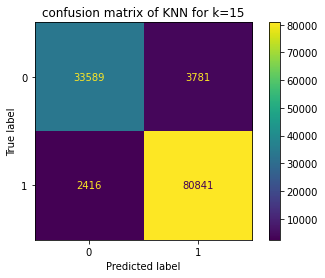

In [14]:
from sklearn.metrics import plot_confusion_matrix

# Plot the confusion matrix for the test set for the KNN classifier
plt.figure()
plot_confusion_matrix(knn, X_test, y_test)
plt.title('confusion matrix of KNN for k=15')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
num_splits = 5
#kfold = KFold(n_splits=num_splits, random_state=10, shuffle=True)

max_comp = X.shape[1]
param_grid = { 'n_neighbors':[5,10,15]}

#pipeline = Pipeline(steps=[('scaler',StandardScaler()), ('estimator', KNeighborsClassifier())])
search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
search.fit(X,y)

print("Best parameter (CV RMSE=%0.3f):" % -search.best_score_)
print(search.best_params_)



Metrics functions

In [ ]:

def separation(tn, fp, fn, tp):
    # change the calculation of the seperation for the two conditions Y_1 and Y_0
    Y_0 = tn / (tn + fn)
    Y_1 = tp / (tp + fp)
  
    return Y_1, Y_0

def sufficiency(tn, fp, fn, tp):
    R_1 = tp / (tp + fn)
    R_0 = fp / (fp + tn)
    return R_1, R_0

# switched tp and tn 
def independence (tp,tn,fn,fp ):
    return (tp + fp) / (tn + fp + fn + tp)

